In [23]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [24]:
models = {
    "BERT": "bert.base",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI-5000",
    "BERT-RTE": "bert.base.finetune-5000-RTE-5000",
    "BERT-QQP": "bert.base.finetune-5000-QQP-5000",
    "BERT-SNLI": "bert.base.finetune-5000-SNLI-5000",
    
    "BERT-MNLIb": "bert.base.finetune-5000-MNLI-5000.concat_bert.base",
    "BERT-QQPb": "bert.base.finetune-5000-QQP-5000.concat_bert.base",
    "BERT-RTEb": "bert.base.finetune-5000-RTE-5000.concat_bert.base",
    "BERT-SNLIb": "bert.base.finetune-5000-SNLI-5000.concat_bert.base",
}

In [25]:
stats = {}

--------

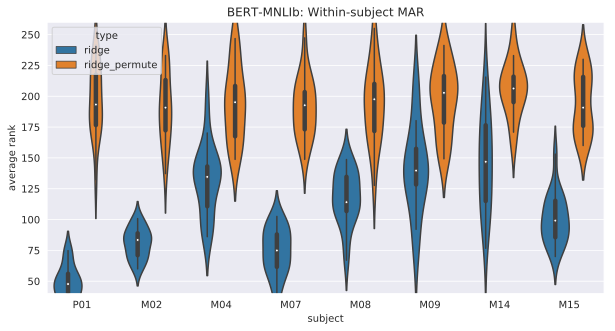

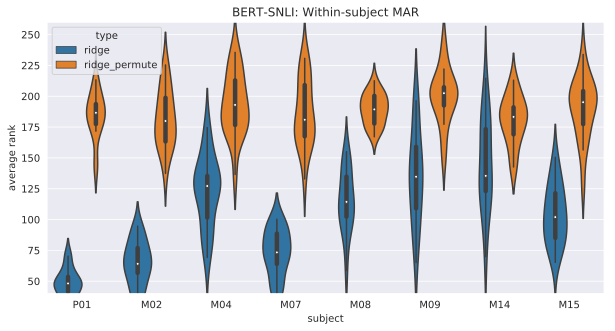

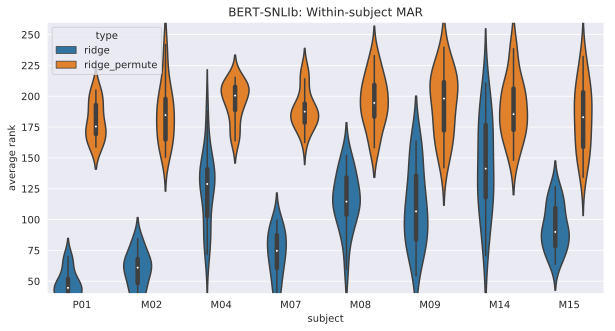

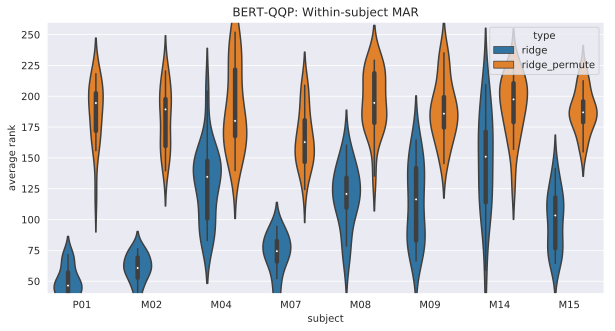

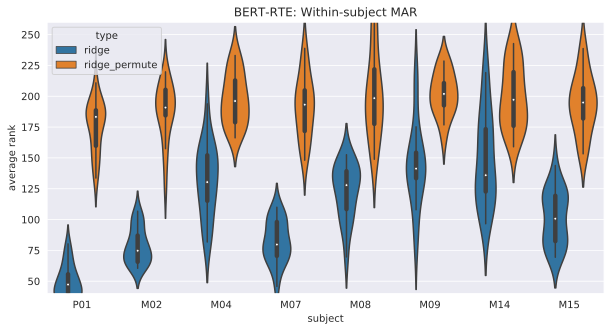

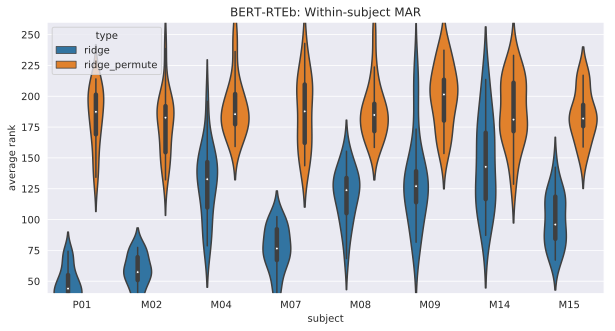

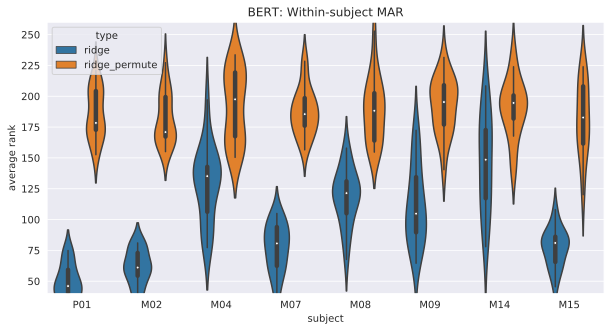

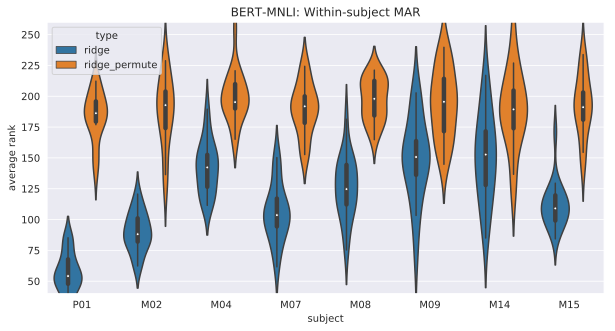

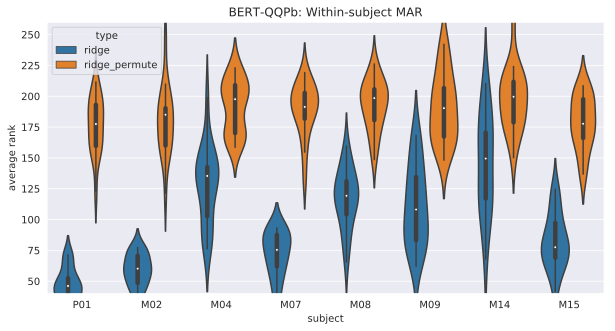

In [26]:
for model, path in models.items():
    f, ax = plt.subplots(figsize=(10,5))
    try:
        stats[model] = util.load_decoding_perf(model, "perf.384sentences.%s.csv" % path, ax=ax)
    except: raise

In [27]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [28]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [29]:
pairs = []
for model in models.keys():
    if model.endswith("b"):
        pairs.append(("BERT", model))
wilcoxon_results = util.wilcoxon_rank_preds(models, pairs=pairs)
wilcoxon_results.head()

w_stat         p_val  p_val_corrected
model1 model2                                              
BERT   BERT-MNLIb  1611597.0  4.732798e-27     1.183200e-27
       BERT-SNLIb  1895163.0  6.746888e-05     1.686722e-05
       BERT-RTEb   1767761.0  1.211925e-10     3.029813e-11
       BERT-QQPb   1809723.5  9.665493e-05     2.416373e-05

In [30]:
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val_corrected"] < 0.01
wilcoxon_results.sort_values("p_val")

w_stat         p_val  p_val_corrected  \
model1 model2                                                 
BERT   BERT-MNLIb  1611597.0  4.732798e-27     1.183200e-27   
       BERT-RTEb   1767761.0  1.211925e-10     3.029813e-11   
       BERT-SNLIb  1895163.0  6.746888e-05     1.686722e-05   
       BERT-QQPb   1809723.5  9.665493e-05     2.416373e-05   

                   significant_bonferroni  
model1 model2                              
BERT   BERT-MNLIb                    True  
       BERT-RTEb                     True  
       BERT-SNLIb                    True  
       BERT-QQPb                     True

---------

# Aggregate graphs

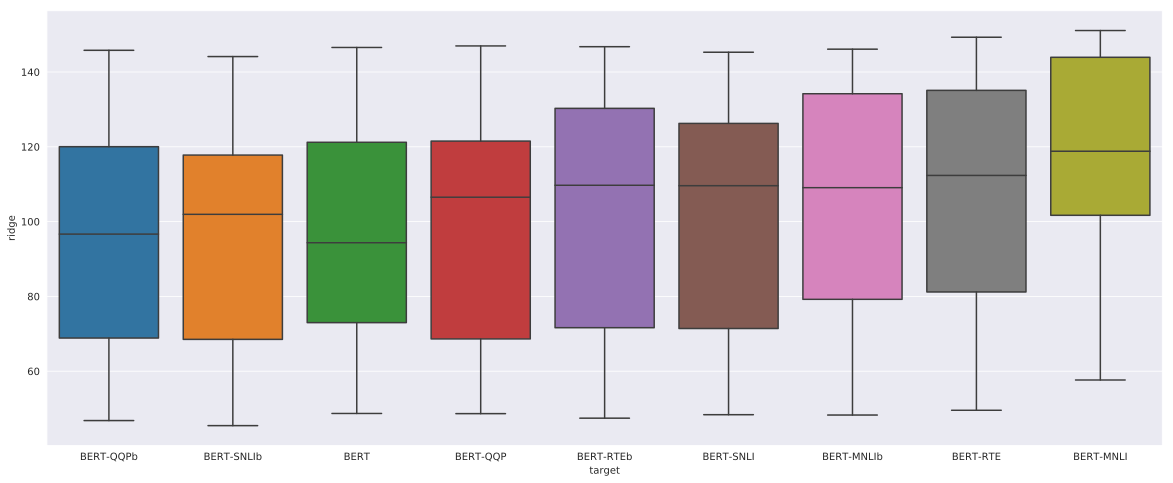

In [31]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [32]:
f.groupby("target").ridge.agg("mean")

target
BERT           96.226190
BERT-MNLI     116.659061
BERT-MNLIb    105.114418
BERT-QQP       98.552249
BERT-QQPb      95.266534
BERT-RTE      107.514550
BERT-RTEb     101.137235
BERT-SNLI     101.234458
BERT-SNLIb     95.558862
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  0. ]


Text(0.87, -0.07, '* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

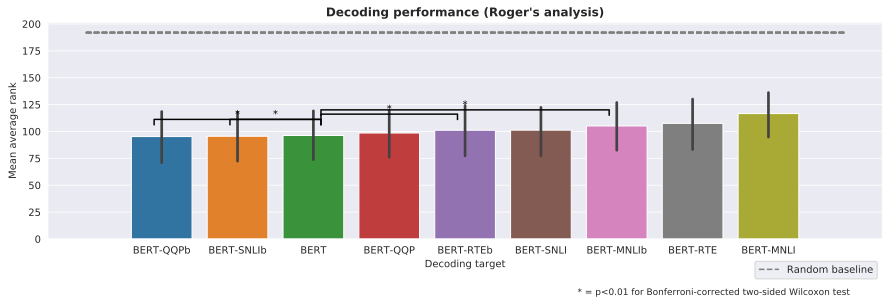

In [33]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance (Roger's analysis)", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
mean_results = f.groupby("target").ridge.agg("mean")
for (m1, m2), row in wilcoxon_results.iterrows():
    significant = row.significant_bonferroni
            
    m1_pos, _ = xticks[m1]
    m2_pos, _ = xticks[m2]
    
    if significant:
        y = max(mean_results[m1], mean_results[m2]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)